In [2]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import SimultaneousActivation, RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from networkx.algorithms.shortest_paths.generic import has_path
import networkx as nx
import panel as pn
import panel.widgets as pnw
import random

In [3]:
def kmtoNaut(km):
    return km / 1.852

In [3]:
data = pd.read_csv('../distances.csv')

In [4]:
data.head()

,Unnamed: 0,trip_count,prev_port,next_port,distance,frequency
0,7682,1984063,4410,3658,460.638148,1.0
1,7062,1948666,3658,7083,372.753814,1.0
2,2712,1287366,7083,7084,26.578906,1.0
3,7248,1950728,7084,2814,9.200892,1.0
4,9021,2408140,2814,4035,345.511726,1.0


In [9]:
N = data["next_port"].tolist()
print(len(N))
N = list(set(N))
print(len(N))

56154
2842


In [5]:
# distances = [
#     ['CAP', 'ROT', 11367.07658],
#     ['CAP', 'SUE', 9814.514498],
#     ['CAP', 'SHA', 14090.03741],
#     ['ROT', 'PSA', 6013.579478],
#     ['PSA', 'SUE', 162.274111],
#     ['SHA', 'SUE', 13162.53259]]

In [11]:
distances = data[["prev_port", "next_port", "distance"]]

In [21]:
distances.astype({'prev_port':'int64', 'next_port':'int64'}).dtypes

prev_port      int64
next_port      int64
distance     float64
dtype: object

In [43]:
G = nx.MultiGraph()
G.add_nodes_from(N) #instatiate the ports as nodes of network
for i in range(len(distances)): #create bi-directional edges with an attribute for length 
       G.add_edge(distances.iloc[i][0], distances.iloc[i][1], length=distances.iloc[i][2])
grid = NetworkGrid(G) #Define Mesa Grid as the just created Network to allow for shipping only in routes

In [50]:
N[1]

49164

In [48]:
G.get_edge_data(N[0],N[1])[0]['length']

TypeError: 'NoneType' object is not subscriptable

In [6]:
for i in range(len(distances)):
    distances[i][2] = kmtoNaut(distances[i][2])

In [31]:
class ShippingNetwork(Model):
    def __init__(self, N, distances, S=2):
        self.ports = N
        self.num_ships = S
        self.distances = distances
        self.schedule = SimultaneousActivation(self)
        self.running = True

        self.G = nx.MultiGraph()
        self.G.add_nodes_from(self.ports) #instatiate the ports as nodes of network
        for i in range(len(distances)): #create bi-directional edges with an attribute for length 
            self.G.add_edge(distances.iloc[i][0], distances.iloc[i][1], length=distances.iloc[i][2])
        self.grid = NetworkGrid(self.G) #Define Mesa Grid as the just created Network to allow for shipping only in routes

        #create ability to remove edges mid-model
        def network_change(self, change_type, change_edge):
            if change_type == "add":
                self.G.add_edge(self.change_edge[0], self.change_edge[1], length=self.change_edge[2])
            if change_type == "remove":
                self.G.remove_edge(self.change_edge[0],self.change_edge[1]) #can we identify an edge by node 1, node 2 & distance?
            #update model with new grid    
            return NetworkGrid(self.G), G


        #create agents 
        Ships = []
        for i in range(self.num_ships):
            port = random.sample(self.ports, k=2) # this is a test - implementation, more complex algorithming is necessary
            a = Ship(i+1, self, self.G, port[0], port[1])
            self.schedule.add(a)
            #append to list of ships
            Ships.append(a)
            #place agent on origin node
            self.grid.place_agent(a, port[0])


        self.datacollector = DataCollector(
            model_reporters={"Ports": "ports", "Graph":"G"},
            agent_reporters={"Position": "position", "Destination":"destination", "Itinerary":"itinerary", "Distance_Traveled":"distance_traveled" })


    def step(self, change_type='', change_edge=[]):
        self.datacollector.collect(self)
        #check network for changes
        if change_type != '' :
            self.grid, self.G = network_change(change_type, change_edge)

        self.schedule.step()     #Run each Agents






In [40]:
class Ship(Agent):
    def __init__(self, unique_id, model, G, start_port, destin_port, s=13.0):
        super().__init__(unique_id, model)
        self.destination = destin_port
        self.state = 0 #0 for active, numbers > 0 for weeks that ships have to "wait" until arrival to port
        self.speed = s*24*7 #speed is given in knots, with 1 knot being 1 nautical mile per hour
        self.position = start_port
        self.init_route = nx.dijkstra_path(G, self.position, self.destination, weight='length') #We keep a copy of the entire itinerary / distance traveled
        self.init_dist = nx.dijkstra_path_length(G,self.position, self.destination, weight='length') 
        self.current_route, self.current_dist = self.init_route, self.init_dist  #For comparison & navigational purposes, we use current route & distance
        self.next_position = self.current_route[1]
        self.itinerary = [self.position] # we keep track of the distance traveled using 
        self.distance_traveled = 0
        self.unique_id = unique_id
        self.G = G
        self.step_size = self.ident_distance()
    

    def routing(self):
        #implement dijkstra to define shortest route
        route = nx.dijkstra_path(self.G, self.position, self.destination, weight='length')
        travel_distance = nx.dijkstra_path_length(self.G,self.position, self.destination, weight='length')
        #include a way for capacity?
        return route, travel_distance

    def move(self):
        self.step_size = self.ident_distance() #look up the distance between two cities 
        self.state = self.step_size / self.speed #change state to step amount
        self.current_dist = self.current_dist - self.step_size #adjust current distance minus the distance traveled in the next step
        self.model.grid.move_agent(self, self.next_position) #move the agent
        self.current_route.remove(self.current_route[0]) #remove the next step from the itinerary
        if len(self.current_route) == 1:
            self.next_position = self.current_route[0] 
        else:
            self.next_position = self.current_route[1] #update current route

    def ident_distance(self): #look up the distance of the current step
        return self.G.get_edge_data(self.position, self.next_position)[0]['length']
    
    def reroute(self):
         pass

    def step(self):
        self.state = self.state - 1 #'move' ships by one weeks progress
        if self.state <= 0: #ships that are en-route to the node they are going to next do not move / perform other activities
            self.distance_traveled += self.step_size #ship has arrived at port, let's add the distance traveled to their 
            self.itinerary.append(self.position) #add the current position to itinerary
            if self.position != self.destination: #if current stop is not the final stop
                new_route, new_distance = self.routing() #perform a new routing to compare against current routing
                if new_route == self.current_route: #if current routing is the same as new, just move (default case)
                    self.move()
                
                """
                THIS IS WEIRD AND CURRENTLY DOESN'T WORK
                """
                elif new_distance > self.current_dist: #if current route is shorter than newly calculated route, check for obstructions
                    for i in range(len(self.current_route)-1):
                        if not has_path(self.G, self.current_route[i], self.current_route[i+1]): 
                            self.current_route = self.new_route
                            self.current_dist = self.new_distance
                    self.move()
                else: # final option is that current route is longer than new route (think Suez reopening after a while), here, we just take the new option
                    self.current_route = self.new_route
                    self.current_dist = self.new_distance
                    self.move()
            
            else: #if ship is arrived at final position, get a new route, and start back
                self.destination = self.reroute()
                self.move()
        print("Ship: {}, Source: {}, Destination: {}, Next Stop {}, Time until next Stop {}".format(self.unique_id, self.itinerary[0], self.itinerary[-1], self.next_position, self.state ))

    
    # def collect_time

    # def collect_costs

In [41]:

model = ShippingNetwork(N, distances)
steps = 2
for i in range(steps):
    model.step()
agent_state = model.datacollector.get_agent_vars_dataframe()
agent_state

Ship: 1, Source: 4058, Destination: 4058, Next Stop 2866.0, Time until next Stop 0.03961354533290368
Ship: 2, Source: 28752, Destination: 28752, Next Stop 2866.0, Time until next Stop 0.45663840841934783
Ship: 1, Source: 4058, Destination: 4058, Next Stop 842.0, Time until next Stop 0.04470496351179487


TypeError: 'NoneType' object is not subscriptable

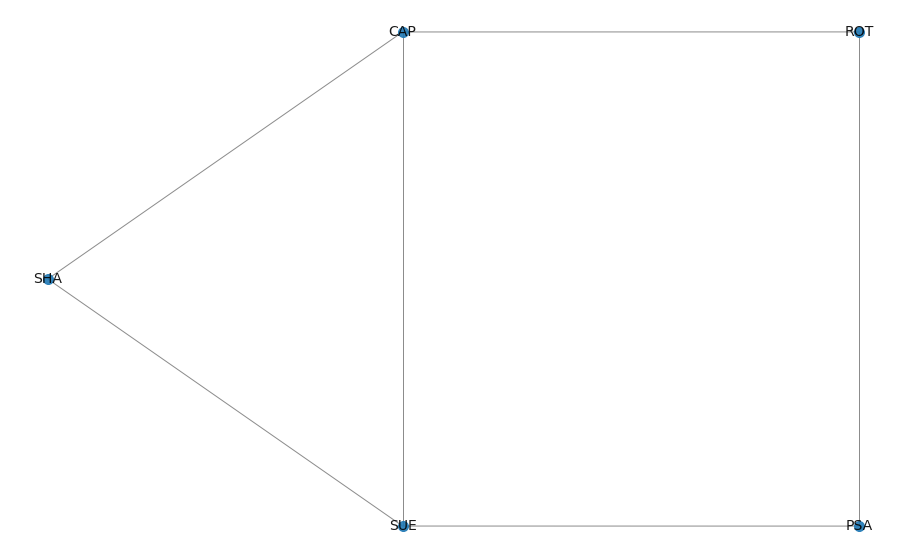

In [14]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["lightblue", "orange", "green",])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()

    nx.draw(graph, pos, node_size=100, edge_color='gray', with_labels=True,
            alpha=0.9,font_size=14,ax=ax)
    ax.set_title(title)
    return

#example usage
fig,ax=plt.subplots(1,2,figsize=(16,10))
model = ShippingNetwork(N, distances)
model.step(distances)
f=plot_grid(model,fig,layout='kamada-kawai')

In [24]:
model.schedule.

[]